In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/ZYXI.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,0.70,0.70,0.70,0.70,0.380843,0
1,1/3/2013,0.70,0.70,0.70,0.70,0.380843,0
2,1/4/2013,0.65,0.65,0.65,0.65,0.353640,17900
3,1/7/2013,0.65,0.65,0.65,0.65,0.353640,3100
4,1/8/2013,0.63,0.65,0.63,0.65,0.353640,9800


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 399.709999.3, cost: -35606.722656, total money: 10074.820001
epoch: 20, total rewards: 56.670003.3, cost: -35623.269531, total money: 9988.000002
epoch: 30, total rewards: 149.280002.3, cost: -35631.871094, total money: 9909.870003
epoch: 40, total rewards: 257.130002.3, cost: -35701.667969, total money: 9982.210005
epoch: 50, total rewards: 159.790002.3, cost: -35729.496094, total money: 9959.510004
epoch: 60, total rewards: 166.560003.3, cost: -35765.558594, total money: 9976.070004
epoch: 70, total rewards: 125.550003.3, cost: -35780.707031, total money: 9966.030005
epoch: 80, total rewards: 134.180002.3, cost: -35807.871094, total money: 9985.590004
epoch: 90, total rewards: 181.030003.3, cost: -35825.339844, total money: 9985.010004
epoch: 100, total rewards: 270.170003.3, cost: -35790.035156, total money: 9947.930003
epoch: 110, total rewards: 329.320000.3, cost: -35818.445312, total money: 9971.630000
epoch: 120, total rewards: 227.599998.3, cost: -3588

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 0.650000, total balance 9999.350000
day 3: buy 1 unit at price 0.650000, total balance 9998.700000
day 4: buy 1 unit at price 0.650000, total balance 9998.050000
day 6: buy 1 unit at price 0.630000, total balance 9997.420000
day 7, sell 1 unit at price 0.630000, investment -3.076920 %, total balance 9998.050000,
day 10, sell 1 unit at price 0.640000, investment -1.538460 %, total balance 9998.690000,
day 11: buy 1 unit at price 0.650000, total balance 9998.040000
day 13, sell 1 unit at price 0.650000, investment 0.000000 %, total balance 9998.690000,
day 14, sell 1 unit at price 0.650000, investment 3.174600 %, total balance 9999.340000,
day 15: buy 1 unit at price 0.650000, total balance 9998.690000
day 16, sell 1 unit at price 0.650000, investment 0.000000 %, total balance 9999.340000,
day 17: buy 1 unit at price 0.620000, total balance 9998.720000
day 18, sell 1 unit at price 0.620000, investment -4.615380 %, total balance 9999.340000,
day 19: buy 1 unit a

day 295, sell 1 unit at price 0.350000, investment -7.894737 %, total balance 9998.190000,
day 297: buy 1 unit at price 0.470000, total balance 9997.720000
day 299, sell 1 unit at price 0.490000, investment 36.111109 %, total balance 9998.210000,
day 300: buy 1 unit at price 0.470000, total balance 9997.740000
day 302, sell 1 unit at price 0.410000, investment 13.888883 %, total balance 9998.150000,
day 303: buy 1 unit at price 0.440000, total balance 9997.710000
day 304: buy 1 unit at price 0.400000, total balance 9997.310000
day 305: buy 1 unit at price 0.470000, total balance 9996.840000
day 306: buy 1 unit at price 0.470000, total balance 9996.370000
day 308, sell 1 unit at price 0.470000, investment 51.612902 %, total balance 9996.840000,
day 310, sell 1 unit at price 0.450000, investment 24.999992 %, total balance 9997.290000,
day 311, sell 1 unit at price 0.430000, investment 43.333330 %, total balance 9997.720000,
day 312, sell 1 unit at price 0.430000, investment -8.510637 %, 

day 485, sell 1 unit at price 0.160000, investment -11.111117 %, total balance 9999.650000,
day 486, sell 1 unit at price 0.160000, investment -11.111117 %, total balance 9999.810000,
day 503: buy 1 unit at price 0.170000, total balance 9999.640000
day 504, sell 1 unit at price 0.180000, investment 5.882356 %, total balance 9999.820000,
day 506: buy 1 unit at price 0.160000, total balance 9999.660000
day 507, sell 1 unit at price 0.150000, investment -6.249994 %, total balance 9999.810000,
day 509: buy 1 unit at price 0.150000, total balance 9999.660000
day 510, sell 1 unit at price 0.140000, investment -6.666670 %, total balance 9999.800000,
day 517: buy 1 unit at price 0.180000, total balance 9999.620000
day 518: buy 1 unit at price 0.180000, total balance 9999.440000
day 521: buy 1 unit at price 0.180000, total balance 9999.260000
day 522: buy 1 unit at price 0.180000, total balance 9999.080000
day 523, sell 1 unit at price 0.180000, investment 0.000000 %, total balance 9999.260000,

day 816: buy 1 unit at price 0.340000, total balance 9999.250000
day 817: buy 1 unit at price 0.340000, total balance 9998.910000
day 818: buy 1 unit at price 0.340000, total balance 9998.570000
day 822, sell 1 unit at price 0.350000, investment 2.941173 %, total balance 9998.920000,
day 823: buy 1 unit at price 0.350000, total balance 9998.570000
day 824, sell 1 unit at price 0.360000, investment 5.882356 %, total balance 9998.930000,
day 826: buy 1 unit at price 0.360000, total balance 9998.570000
day 827: buy 1 unit at price 0.360000, total balance 9998.210000
day 829, sell 1 unit at price 0.360000, investment 5.882356 %, total balance 9998.570000,
day 830, sell 1 unit at price 0.360000, investment 2.857149 %, total balance 9998.930000,
day 831: buy 1 unit at price 0.360000, total balance 9998.570000
day 832: buy 1 unit at price 0.340000, total balance 9998.230000
day 833: buy 1 unit at price 0.340000, total balance 9997.890000
day 834: buy 1 unit at price 0.340000, total balance 99

day 989, sell 1 unit at price 0.290000, investment 7.407400 %, total balance 9996.210000,
day 990: buy 1 unit at price 0.320000, total balance 9995.890000
day 991, sell 1 unit at price 0.330000, investment 22.222222 %, total balance 9996.220000,
day 992, sell 1 unit at price 0.320000, investment 23.076925 %, total balance 9996.540000,
day 993, sell 1 unit at price 0.330000, investment 3.125006 %, total balance 9996.870000,
day 994: buy 1 unit at price 0.330000, total balance 9996.540000
day 995, sell 1 unit at price 0.330000, investment 3.125006 %, total balance 9996.870000,
day 996, sell 1 unit at price 0.320000, investment 14.285711 %, total balance 9997.190000,
day 997: buy 1 unit at price 0.330000, total balance 9996.860000
day 998, sell 1 unit at price 0.330000, investment 0.000000 %, total balance 9997.190000,
day 999, sell 1 unit at price 0.330000, investment 3.125006 %, total balance 9997.520000,
day 1000, sell 1 unit at price 0.330000, investment 3.125006 %, total balance 9997

day 1178: buy 1 unit at price 1.580000, total balance 9989.660000
day 1179, sell 1 unit at price 1.540000, investment 113.888875 %, total balance 9991.200000,
day 1181: buy 1 unit at price 1.840000, total balance 9989.360000
day 1184, sell 1 unit at price 1.870000, investment 156.164378 %, total balance 9991.230000,
day 1185: buy 1 unit at price 1.790000, total balance 9989.440000
day 1186, sell 1 unit at price 1.740000, investment 138.356160 %, total balance 9991.180000,
day 1187: buy 1 unit at price 1.820000, total balance 9989.360000
day 1188, sell 1 unit at price 1.830000, investment 140.789483 %, total balance 9991.190000,
day 1189, sell 1 unit at price 1.800000, investment 143.243233 %, total balance 9992.990000,
day 1190, sell 1 unit at price 1.850000, investment 160.563391 %, total balance 9994.840000,
day 1191, sell 1 unit at price 1.870000, investment 142.857149 %, total balance 9996.710000,
day 1192: buy 1 unit at price 1.810000, total balance 9994.900000
day 1194: buy 1 uni

day 1345, sell 1 unit at price 3.370000, investment -3.714289 %, total balance 10010.470001,
day 1346, sell 1 unit at price 3.600000, investment 13.207542 %, total balance 10014.070001,
day 1347, sell 1 unit at price 3.520000, investment -2.762428 %, total balance 10017.590001,
day 1348: buy 1 unit at price 3.100000, total balance 10014.490001
day 1350: buy 1 unit at price 3.080000, total balance 10011.410001
day 1351: buy 1 unit at price 3.100000, total balance 10008.310001
day 1352, sell 1 unit at price 3.050000, investment -15.277777 %, total balance 10011.360001,
day 1353: buy 1 unit at price 3.200000, total balance 10008.160001
day 1354: buy 1 unit at price 3.250000, total balance 10004.910001
day 1355: buy 1 unit at price 3.100000, total balance 10001.810001
day 1357, sell 1 unit at price 3.100000, investment -6.626507 %, total balance 10004.910001,
day 1358, sell 1 unit at price 3.100000, investment -11.428574 %, total balance 10008.010001,
day 1364: buy 1 unit at price 3.420000

day 1512: buy 1 unit at price 2.950000, total balance 10020.990001
day 1513, sell 1 unit at price 2.960000, investment -3.896100 %, total balance 10023.950001,
day 1514, sell 1 unit at price 2.940000, investment 3.157900 %, total balance 10026.890001,
day 1515: buy 1 unit at price 3.000000, total balance 10023.890001
day 1516, sell 1 unit at price 3.000000, investment -0.662251 %, total balance 10026.890001,
day 1517, sell 1 unit at price 3.000000, investment -0.332226 %, total balance 10029.890001,
day 1518, sell 1 unit at price 3.010000, investment 4.152245 %, total balance 10032.900001,
day 1519, sell 1 unit at price 3.100000, investment 5.084741 %, total balance 10036.000001,
day 1520: buy 1 unit at price 3.090000, total balance 10032.910001
day 1522: buy 1 unit at price 3.330000, total balance 10029.580002
day 1523, sell 1 unit at price 3.340000, investment 11.333330 %, total balance 10032.920001,
day 1524: buy 1 unit at price 3.440000, total balance 10029.480001
day 1527: buy 1 u

day 1696: buy 1 unit at price 9.510000, total balance 10045.399998
day 1697, sell 1 unit at price 9.510000, investment 0.000000 %, total balance 10054.909999,
day 1698: buy 1 unit at price 9.730000, total balance 10045.179999
day 1699: buy 1 unit at price 10.780000, total balance 10034.399999
day 1700: buy 1 unit at price 11.800000, total balance 10022.599999
day 1701, sell 1 unit at price 12.510000, investment 28.571437 %, total balance 10035.109999,
day 1702, sell 1 unit at price 12.430000, investment 15.306128 %, total balance 10047.540000,
day 1703, sell 1 unit at price 11.420000, investment -3.220340 %, total balance 10058.960000,
day 1708: buy 1 unit at price 11.830000, total balance 10047.130000
day 1709, sell 1 unit at price 11.120000, investment -6.001691 %, total balance 10058.250000,
day 1711: buy 1 unit at price 10.480000, total balance 10047.770000
day 1712, sell 1 unit at price 10.880000, investment 3.816799 %, total balance 10058.650000,
day 1715: buy 1 unit at price 9.3

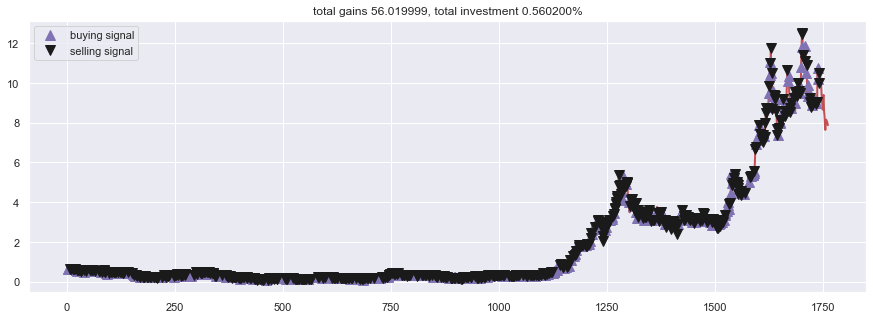

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()